# Summary
#### * The portfolio will have simulated weights on individual companies within a given portfolio to obtain an understanding on what return to risk is desired by the individual.
#### * Ten securities will be utizlied where they are are spread out in their corresponding industries such that we have a relatively "low" correlation with each other.

#### Companies:
##### Google | NVIDIA | Facebook
##### Wells Fargo | Pfizer | COKE
##### Disney | IMAX | Catepillar
##### Southwest Airlines

## 1.  Initiate Packages

In [13]:
import re
from io import StringIO
from datetime import datetime, timedelta
import requests
import pandas as pd
import numpy as np

## 2.  Obtain Securities Data
##### * The portfolio will utilize data from 6 years back
##### * The portolio will use the most recent 1 year to determine how well it would have done if I follow the efficient frontier.
##### * I will get the adjusted close as my main data.

In [14]:

from datetime import datetime
import yfinance as yf
yf.pdr_override() 
from pandas_datareader import data as pdr

#* This function will return a pd dataframe with all of the adjusted closing information
def get_historical_Data(tickers):
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data,pdr.get_data_yahoo(i, start=datetime(2013, 10, 11), end=datetime(2020, 10, 11)).iloc[:,4]], axis = 1)
        names.append(i)
    data.columns = names
    return data


#*  The ticker names of the companies that we will be looking at.
ticks = ["GOOG", "NVDA", "META", "WFC","DIS", "IMAX", "LUV", "PFE", "COKE", "CAT"]
stockData = get_historical_Data(ticks)
print(stockData.shape)

#* Most Recent Data
stockData.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(1762, 10)


,GOOG,NVDA,META,WFC,DIS,IMAX,LUV,PFE,COKE,CAT
2020-10-05 00:00:00-04:00,74.301003,136.138397,264.649994,23.311455,123.370003,11.06,38.292503,31.875391,239.467346,145.311340
2020-10-06 00:00:00-04:00,72.671997,137.076431,258.660004,23.054028,120.930000,11.43,37.387173,31.372328,239.487091,143.455780
2020-10-07 00:00:00-04:00,73.014503,139.346634,258.119995,23.654690,122.910004,11.37,38.391991,31.632532,236.624573,146.523163
2020-10-08 00:00:00-04:00,74.296501,138.096771,263.760010,24.121870,123.089996,11.62,38.789940,31.996826,237.226669,148.312469
2020-10-09 00:00:00-04:00,75.761002,137.338364,264.450012,24.121870,124.980003,11.62,39.526138,31.910089,239.161346,150.470932


## 2. Splitting Data
#### * The data will be split into a training and testing set.
#### * The training set will be related to monte carlo simulation, this is where the portfolio will be extracting the weights.
#### * The testing set will be using this as a judge of how well our portfoilio has done if we have invested 1-yr back in the past.

In [15]:

# Saving the most recent year data such that we can compare...
# Called dT (DataTest)
dT = stockData.iloc[stockData.shape[0] - 252:,:] # Data test

# Update the "Training" or "data full"
d = stockData.iloc[:stockData.shape[0] - 252,:] # Data Train for the Simulation

print("Testing Data dimensions: ", dT.shape)
print("Training Data dimensions:", d.shape)
dT

Testing Data dimensions:  (252, 10)
Training Data dimensions: (1510, 10)


,GOOG,NVDA,META,WFC,DIS,IMAX,LUV,PFE,COKE,CAT
2019-10-11 00:00:00-04:00,60.772499,46.302898,184.190002,44.882679,129.245667,20.879999,53.264263,30.109533,287.464386,117.798286
2019-10-14 00:00:00-04:00,60.856998,46.437332,183.279999,44.937397,128.927551,20.680000,53.372921,30.267963,286.028992,117.779961
2019-10-15 00:00:00-04:00,62.150501,48.887035,188.889999,45.703537,128.987198,20.549999,53.501343,30.434731,282.971497,120.211159
2019-10-16 00:00:00-04:00,62.181999,48.349300,189.550003,45.229256,130.080658,20.459999,53.017300,30.301315,286.274780,119.440506
2019-10-17 00:00:00-04:00,62.653500,48.369213,190.389999,45.247501,131.581650,21.080000,53.204994,30.401377,286.962982,121.165276
...,...,...,...,...,...,...,...,...,...,...
2020-10-05 00:00:00-04:00,74.301003,136.138397,264.649994,23.311455,123.370003,11.060000,38.292503,31.875391,239.467346,145.311340
2020-10-06 00:00:00-04:00,72.671997,137.076431,258.660004,23.054028,120.930000,11.430000,37.387173,31.372328,239.487091,143.455780
2020-10-07 00:00:00-04:00,73.014503,139.346634,258.119995,23.654690,122.910004,11.370000,38.391991,31.632532,236.624573,146.523163
2020-10-08 00:00:00-04:00,74.296501,138.096771,263.760010,24.121870,123.089996,11.620000,38.789940,31.996826,237.226669,148.312469


##### * training set

In [16]:
d

,GOOG,NVDA,META,WFC,DIS,IMAX,LUV,PFE,COKE,CAT
2013-10-11 00:00:00-04:00,21.718344,3.581409,49.110001,31.580761,60.191032,26.459999,14.244337,19.357405,58.281540,65.444901
2013-10-14 00:00:00-04:00,21.820959,3.635387,49.509998,31.824671,60.754677,26.850000,14.319161,19.782028,58.206306,65.926483
2013-10-15 00:00:00-04:00,21.967909,3.616612,49.500000,31.664612,60.400135,26.389999,14.216280,19.653963,58.281540,65.551918
2013-10-16 00:00:00-04:00,22.366913,3.661203,51.139999,32.175320,60.318302,26.700001,14.590390,20.085333,58.883343,65.949425
2013-10-17 00:00:00-04:00,22.136776,3.668245,52.209999,32.533588,60.381958,26.660000,14.973859,20.395372,59.673222,66.087975
...,...,...,...,...,...,...,...,...,...,...
2019-10-04 00:00:00-04:00,60.450001,45.302109,180.449997,44.882679,129.494171,21.389999,52.148006,29.959446,302.014587,111.046013
2019-10-07 00:00:00-04:00,60.383999,45.889633,179.679993,44.517857,130.120407,21.070000,52.394966,29.876066,296.715546,110.321228
2019-10-08 00:00:00-04:00,59.456501,44.122059,177.750000,43.614910,127.704887,20.870001,52.385086,29.542528,289.961517,108.229500
2019-10-09 00:00:00-04:00,60.115501,44.988422,179.850006,43.915890,128.559769,20.799999,52.839489,29.759327,289.853424,109.578102


## 3.  Calculating Returns
#### * This section will calculate the daily returns, annualized returns, compound annual growthrate(geometric mean) and average aritmetic returns.

In [17]:
from scipy import stats
# * Daily returns 
expected_returns_a = d.pct_change() 

# * Column names
expected_returns_a.columns = ticks  

# * Annualizing the average rate of return
expected_returns_aA = pd.DataFrame(expected_returns_a.mean()*250) 

# * Transposing values 
expected_returns_aA = expected_returns_aA.T 

# * dar ==> is your daily avg return... it is the % change day to day
dar = d.pct_change().iloc[1:,:]+1 

# * Geometric Average Rate of Return
gar = pd.DataFrame(np.prod(dar)**(1/float(6)) - 1) 

full_return_annual = (pd.concat([expected_returns_aA.T, gar], axis = 1))

full_return_annual.columns = ["Average Arithmetic Returns", "Average Geometric Returns"] 
print("Expected Annual Returns ", expected_returns_aA)
print("dar", dar)
print("Full Annual Return", full_return_annual)

Expected Annual Returns         GOOG      NVDA      META       WFC       DIS      IMAX       LUV  \
0  0.198358  0.500861  0.260655  0.076283  0.144291  0.007926  0.256635   

        PFE      COKE       CAT  
0  0.087328  0.319925  0.122425  
dar                                GOOG      NVDA      META       WFC       DIS  \
2013-10-14 00:00:00-04:00  1.004725  1.015072  1.008145  1.007723  1.009364   
2013-10-15 00:00:00-04:00  1.006734  0.994836  0.999798  0.994971  0.994164   
2013-10-16 00:00:00-04:00  1.018163  1.012330  1.033131  1.016129  0.998645   
2013-10-17 00:00:00-04:00  0.989711  1.001923  1.020923  1.011135  1.001055   
2013-10-18 00:00:00-04:00  1.137963  1.011516  1.038498  1.000000  1.010991   
...                             ...       ...       ...       ...       ...   
2019-10-04 00:00:00-04:00  1.017822  1.003640  1.005965  1.015058  1.016543   
2019-10-07 00:00:00-04:00  0.998908  1.012969  0.995733  0.991872  1.004836   
2019-10-08 00:00:00-04:00  0.984640  0.96

## 4.  Risk Metrics
#### * This section will calculate the sharpe ratio, stadard deviation/volaitily and expected return.
#### * Stock weights will be randomized to help us generate our results for the monte carlo portfolio returns.
#### * In addition, the portfolio will run through 100,000 iterations.

In [18]:

# * The Three lists will be utilized for retaining returns, volatility, and weights of the Simulated portfolios
portfolio_returns = []
portfolio_volatility = []
sharpe_ratio = []

# * stock_weights will help the portoflio generate randomized returns 
stock_weights = []

# * Number of Indiviudal securities that will be a part of the portfolio
num_assets = len(ticks)
# Number of simulated iterations
num_portfolios = 100000

# * Daily Returns
daily_returns = d.pct_change()

# * Converting daily returns to annual returns (standardizing to a year)
annual_returns = (daily_returns.mean() * 250) + 1

# * Obtaining  covariance and annualized covariance
cov_daily = daily_returns.cov() 
cov_annual = cov_daily*250 

print(annual_returns)

GOOG    1.198358
NVDA    1.500861
META    1.260655
WFC     1.076283
DIS     1.144291
IMAX    1.007926
LUV     1.256635
PFE     1.087328
COKE    1.319925
CAT     1.122425
dtype: float64


In [19]:
# Setting seed of interpretability
np.random.seed(3)
# Filling in the lists with a simulated return, risk, and a given weight
# num_portfolios
for i in range(num_portfolios):
    # Randomly assign weights
    weights = np.random.random(num_assets)
    # Standardize the weights
    weights /= np.sum(weights)
    returns = (np.dot(weights, (annual_returns)))
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    """
    sharpe ratio: This calculates the risk adjusted return
    It suggests that adding assets to a portfolio that have low correlation can decrease portfolio risk without 
    sacrificing return 
    """
    sharpe = ((returns-1) / volatility)
    sharpe_ratio.append(sharpe)
    portfolio_returns.append(returns-1)
    portfolio_volatility.append(volatility)
    stock_weights.append(weights)

## 5. Monte Carlo Simulation Summary


In [20]:

# Storing the portfolio values
portfolio = {'Returns': portfolio_returns,
             'Volatility': portfolio_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Add an additional entry to the portfolio such that each indivudal weight is incorporated for its corresponding company
for counter,symbol in enumerate(ticks):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)
df

,Returns,Volatility,Sharpe Ratio,GOOG Weight,NVDA Weight,META Weight,WFC Weight,DIS Weight,IMAX Weight,LUV Weight,PFE Weight,COKE Weight,CAT Weight
0,0.178703,0.172273,1.037326,0.117817,0.151475,0.062225,0.109267,0.191004,0.191719,0.026863,0.044330,0.011009,0.094290
1,0.181829,0.163057,1.115125,0.007585,0.115987,0.164814,0.070706,0.171697,0.150017,0.006089,0.141890,0.065823,0.105392
2,0.200293,0.172511,1.161041,0.059669,0.145874,0.092695,0.033013,0.114624,0.164221,0.064476,0.046712,0.081650,0.197066
3,0.219789,0.167687,1.310711,0.172284,0.118690,0.159369,0.149293,0.066724,0.016278,0.115341,0.098471,0.063824,0.039727
4,0.183750,0.165982,1.107046,0.093302,0.107628,0.061793,0.066970,0.105045,0.197504,0.134553,0.065064,0.063799,0.104342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.194760,0.164499,1.183957,0.023417,0.100606,0.149373,0.154120,0.074488,0.159411,0.057221,0.058428,0.151602,0.071334
99996,0.175594,0.154375,1.137445,0.038546,0.042940,0.052623,0.041529,0.091245,0.162005,0.171378,0.167278,0.142067,0.090388
99997,0.204151,0.172983,1.180177,0.034737,0.173086,0.129049,0.129066,0.000071,0.106695,0.022480,0.137896,0.079701,0.187218
99998,0.200551,0.167721,1.195743,0.139549,0.107646,0.161297,0.101648,0.067403,0.157787,0.046113,0.080258,0.113453,0.024847


## 6. Efficient Frontier Chart

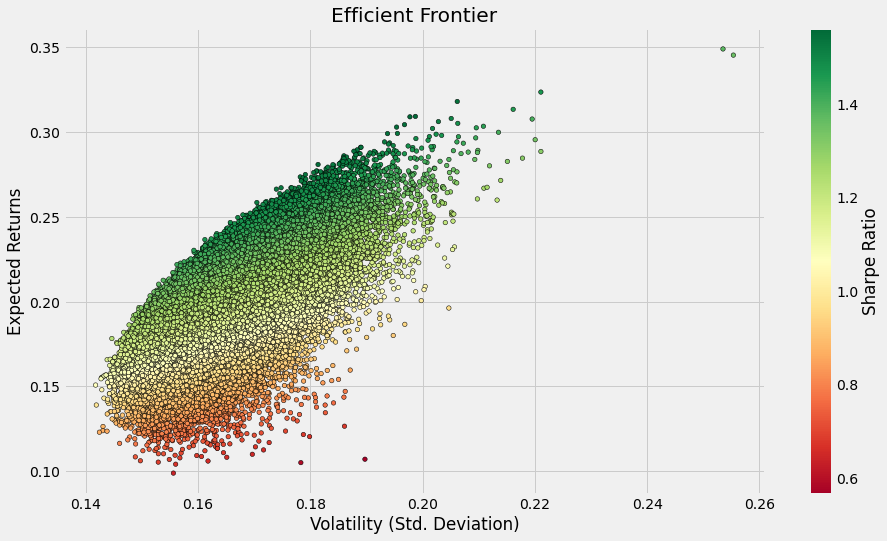

In [21]:
# PLotting the efficient frontier.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(14, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

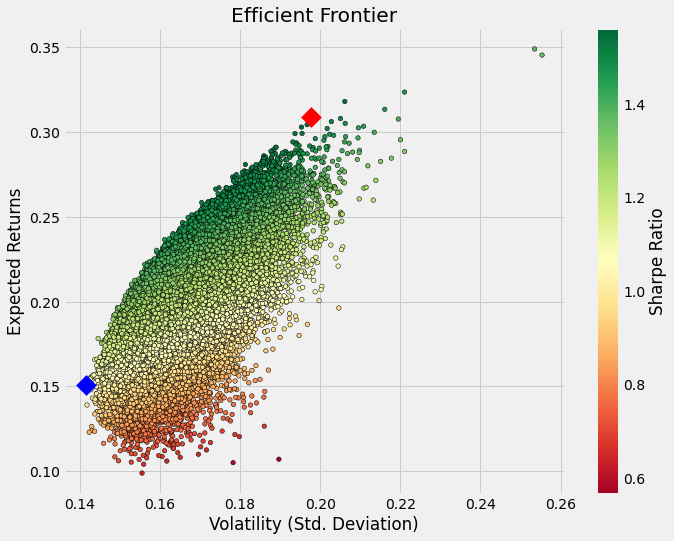

In [22]:
# 
# * Find minimum volatility
min_volatility = df['Volatility'].min()

# * Find max Sharpe Ratio
max_sharpe = df['Sharpe Ratio'].max()

# * utilize variables above to locate and create two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# * plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [23]:

# *  Minimum Risk Adjusted Values and Max Risk Adjusted Values
r_ef = pd.concat([min_variance_port.T,sharpe_portfolio.T], axis = 1)
r_ef.columns = ["Minimum Risk Adjusted Values", "Max Risk Adjusted Values"]
print(r_ef)

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.150794                  0.309052
Volatility                        0.141734                  0.197737
Sharpe Ratio                      1.063918                  1.562948
GOOG Weight                       0.035359                  0.106809
NVDA Weight                       0.018026                  0.250944
META Weight                       0.011483                  0.038666
WFC Weight                        0.089905                  0.007228
DIS Weight                        0.197421                  0.060073
IMAX Weight                       0.040720                  0.005087
LUV Weight                        0.103566                  0.206534
PFE Weight                        0.299035                  0.006567
COKE Weight                       0.092985                  0.254782
CAT Weight                        0.111500                  0.063310


## 7. Summary of Results

In [24]:
amount_invest = 10000
expected_return = pd.DataFrame(amount_invest * (1+r_ef.iloc[0,:]))
print("----------------------------------------------------------------")
print("                Expected Returns on my Portfolio")
print("----------------------------------------------------------------")
print(expected_return.T)
print("")
print("----------------------------------------------------------------")
print("If I invested", amount_invest,"USD on |", dT.index[0],"| I would have...")
actual_return = (dT.iloc[dT.shape[0]-1,:] - dT.iloc[0,:]) / ( dT.iloc[0,:])
# Multipling the weights to the price at the beginning of the year
beg_price = (dT.iloc[0,:])
end_price = dT.iloc[dT.shape[0]-1,:]
print("----------------------------------------------------------------")

# * Weights derived from the Efficient Frontier Portfolio
# * Weights for Minimum Risk
w = np.array(r_ef.iloc[3:,0])

percentage_change = (end_price - beg_price)/(beg_price)+1
print("Using the Portfolio Weights for Minimum Risk Return Portfolio")
money_left = sum(w * percentage_change* amount_invest)
print("")
print("    Starting balance $ 1000 : Ending with $ ",round(money_left, 2))
print("")
print("----------------------------------------------------------------")
print("Using the Portfolio Weights Maximized Risk-Return Portfolio")

# * Weights for Maxmimum Risk
w1 = np.array(r_ef.iloc[3:,1])

money_left1 = sum(w1 * percentage_change* amount_invest)
print("")
print("    Starting balance $ 10,000 : Ending with $ ", round(money_left1,2))
print("")

----------------------------------------------------------------
                Expected Returns on my Portfolio
----------------------------------------------------------------
         Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                  11507.938357              13090.521467

----------------------------------------------------------------
If I invested 10000 USD on | 2019-10-11 00:00:00-04:00 | I would have...
----------------------------------------------------------------
Using the Portfolio Weights for Minimum Risk Return Portfolio

    Starting balance $ 1000 : Ending with $  9894.76

----------------------------------------------------------------
Using the Portfolio Weights Maximized Risk-Return Portfolio

    Starting balance $ 10,000 : Ending with $  14508.59

